<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/03-24-2020.csv"
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [182]:
us_pop = 329968629  #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US: {res.positive/us_pop*100:2f}%")

positive     63675
negative    355135
pending      14735
total       433545
dtype: int64
Current Infection Rate 14.687057%
Percentage of US: 0.019297%


In [183]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,30811,72668
34,NJ,4402,10452
52,WA,2469,31712
24,MI,2294,2069
5,CA,2102,13452
16,IL,1865,12344
21,MA,1838,17956
20,LA,1795,9656
10,FL,1682,15374
11,GA,1247,4932


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [185]:
dfUSAPos[-7:]

,date,positive,PCT
15,20200319,11723,0.184107
16,20200320,17038,0.267578
17,20200321,23203,0.364397
18,20200322,31888,0.500793
19,20200323,42164,0.662175
20,20200324,51970,0.816176
21,20200325,63675,1.000000


In [186]:
dfCAPos[-7:]

,date,positive,PCT
15,20200319,924,0.439581
16,20200320,1063,0.505709
17,20200321,1279,0.608468
18,20200322,1536,0.730733
19,20200323,1733,0.824453
20,20200324,2102,1.000000
21,20200325,2102,1.000000


In [187]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,
20200321,23203,155909,3477,1964.0,272,182589,179112,53.0,1964.0,37762.0,6165.0,43927.0
20200322,31888,193463,2842,2554.0,398,228193,225351,126.0,590.0,37554.0,8685.0,46239.0
20200323,42164,237321,14571,3325.0,471,294056,279485,73.0,771.0,43858.0,10276.0,54134.0
20200324,51970,292758,14433,4468.0,675,359161,344728,204.0,1143.0,55437.0,9806.0,65243.0
20200325,63675,355135,14735,6136.0,887,433545,418810,212.0,1668.0,62377.0,11705.0,74082.0


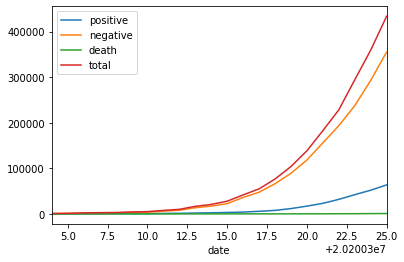

In [188]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [189]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
20200312,987,29
20200313,1264,36
20200314,1678,41
20200315,1678,41
20200316,1678,41
20200317,3503,58
20200318,3536,58
20200319,7087,100
20200320,10442,150


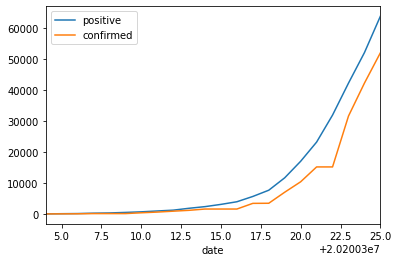

In [190]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [191]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalized,death,total,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,
20200319,924,8787,0,0.0,18,9711,9711,5.0,0.0,806.0,313.0,1119.0
20200320,1063,10424,0,0.0,20,11487,11487,2.0,0.0,1637.0,139.0,1776.0
20200321,1279,11249,0,0.0,24,12528,12528,4.0,0.0,825.0,216.0,1041.0
20200322,1536,11304,0,0.0,27,12840,12840,3.0,0.0,55.0,257.0,312.0
20200323,1733,12567,12100,0.0,27,26400,14300,0.0,0.0,1263.0,197.0,1460.0
20200324,2102,13452,12100,0.0,40,27654,15554,13.0,0.0,885.0,369.0,1254.0
20200325,2102,13452,12100,0.0,40,27654,15554,0.0,0.0,0.0,0.0,0.0


In [192]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    53740
dead           706
dtype: int64

In [193]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    2538
dead           50
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [195]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
China             81591
Italy             69176
US                53740
Spain             39885
Germany           32986
Iran              24811
France            22622
Switzerland        9877
Korea, South       9037
United Kingdom     8164
Name: confirmed, dtype: int64

In [196]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(20)

country
China             81591
Italy             69176
US                53740
Spain             39885
Germany           32986
Iran              24811
France            22622
Switzerland        9877
Korea, South       9037
United Kingdom     8164
Netherlands        5580
Austria            5283
Belgium            4269
Norway             2863
Canada             2790
Portugal           2362
Sweden             2286
Brazil             2247
Australia          2044
Israel             1930
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [201]:
dfState.loc['NY'].head(7)

,date,positive,current_total,pct
state,,,,
NY,20200325,30811,30811,1.000000
NY,20200324,25665,30811,0.832982
NY,20200323,20875,30811,0.677518
NY,20200322,15168,30811,0.492292
NY,20200321,10356,30811,0.336114
NY,20200320,7102,30811,0.230502
NY,20200319,4152,30811,0.134757


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

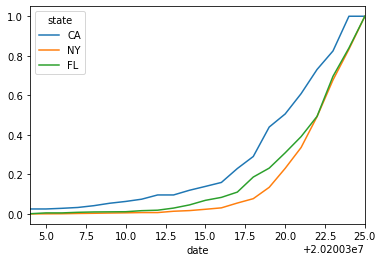

In [203]:
x = res.loc[:, ['CA','NY','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

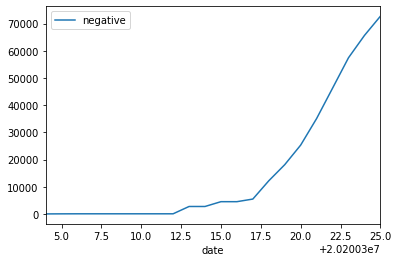

In [205]:
x = dfNYTesting.plot.line()

In [206]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['GA']))].head(10)

,state,date,positive,current_total,pct
216,GA,20200325,1247,1247,1.000000
217,GA,20200324,1026,1247,0.822775
218,GA,20200323,772,1247,0.619086
219,GA,20200322,600,1247,0.481155
220,GA,20200321,507,1247,0.406576
221,GA,20200320,420,1247,0.336808
222,GA,20200319,287,1247,0.230152
223,GA,20200318,197,1247,0.157979
224,GA,20200317,146,1247,0.117081
225,GA,20200316,121,1247,0.097033


In [207]:
datecutoff = int(((pd.to_datetime(str(dfDates.date.max())))-datetime.timedelta(days=2)).strftime("%Y%m%d"))
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .60)].sort_values(by='positive',ascending=False)


,state,date,positive,current_total,pct
471,MI,20200323,1328,2294,0.578901
409,MA,20200323,777,1838,0.422742
809,PA,20200323,644,1127,0.571429
136,CT,20200323,415,875,0.474286
920,TX,20200323,352,974,0.361396
579,NC,20200323,297,504,0.589286
71,AZ,20200323,265,450,0.588889
330,IN,20200323,259,477,0.542977
512,MO,20200323,183,356,0.514045
22,AL,20200323,167,283,0.590106
